# Load finch data in motif-trialized format

In [1]:
# # Install and restart kernel
!pip install quantities
!pip install elephant
!pip install -e git+https://github.com/pabloslash/songbirdcore.git#egg=songbirdcore

import matplotlib.pyplot as plt
from scipy import signal
import pickle as pkl
import numpy as np
import quantities

from songbirdcore.utils.plot_utils import plot_as_raster
import songbirdcore.spikefinder.spike_analysis_helper as sh
import songbirdcore.utils.plot_utils as puts
import songbirdcore.utils.label_utils as luts
from songbirdcore.utils.style_params import syl_colors as colors

In [2]:
def ms_spectrogram(x, s_f, n_window=512, step_ms=1, f_min=100, f_max=9000, cut_off=0.000055):

    # the overlap is the size of the window minus the smples in a msec
    msec_samples = int(s_f * 0.001)
    n_overlap = n_window - msec_samples * step_ms
    sigma = 1 / 200. * s_f

    # Make the spectrogram
    f, t, Sxx = signal.spectrogram(x, s_f,
                                   nperseg=n_window,
                                   noverlap=n_overlap,
                                   window=signal.gaussian(n_window, sigma),
                                   scaling='spectrum')
    if cut_off > 0:
        Sxx[Sxx < np.max((Sxx) * cut_off)] = 1
    Sxx[f<f_min, :] = 1
    return f[(f>f_min) & (f<f_max)], t, Sxx[(f>f_min) & (f<f_max)]
    
def plot_spectrogram(audio, fs_audio, ax=None):
    
    if ax == None:
        fig, ax = plt.subplots(nrows=1, figsize=(10, 3))
    f, tm, sxx = ms_spectrogram(audio, fs_audio, n_window=512, step_ms=1, f_min=500, f_max=8500, cut_off=5.5e-05)
    ax.pcolormesh(tm, f, np.log(sxx), cmap='inferno')

    ax.set_xlabel('time (s)', fontsize=30)

    ax.set_ylabel('f (kHz)', fontsize=30)
    ax.set_yticklabels(['0', '2', '4', '6', '8'], fontsize=25)


## 1) Raw spiketrains

keys():

- **'neural_dict'**: dictionary containing the raw spiketrains (spike sorted clusters) of well isolated units (_sua) and all identified clusters (_all) in HVC and RA. Spiketrains are stored in [trials x clustes x timesamps] format. e.g. (47, 84, 26999)

- **'audio_motifs'**: Audio trials in [trials x timesamps] format. e.g. (47, 22499)
  
- **'audio_labels'**: Syllable labels for audio trials in [trials x timesamps] format. e.g. (47, 22499)
  
- **'fs_neural'**: Sampling frequency of neural traces. e.g. 30kHz.
  
- **'fs_audio'**: Sampling frequency of audio recordings. e.g. 25kHz.
  
- **'t_pre'**: Time before alignment sample (onset of syllable 1).
  
- **'t_post'**: Time after alignment sample (onset of syllable 1).
  
- **'sess_params'**: Experiment metadata (bird, session, probe etc.).

In [3]:
spiketrain_filename = 'RAW_z_r12r13_21_20240328_185716.pkl'

with open(spiketrain_filename, 'rb') as file:
    spiketrain_dict = pkl.load(file)

# Unpack dictionary
spiketrains = spiketrain_dict['neural_dict']
audio_motifs = spiketrain_dict['audio_motifs']
audio_labels = spiketrain_dict['audio_labels']
fs_neural = spiketrain_dict['fs_neural']
fs_audio = spiketrain_dict['fs_audio']
t_pre, t_post = spiketrain_dict['t_pre'], spiketrain_dict['t_post']
sess_params = spiketrain_dict['sess_params']

### Plot example motif with a few random neural rasters 

/tmp/ipykernel_1956/2700667904.py:12: DeprecationWarning: Importing gaussian from 'scipy.signal' is deprecated and will raise an error in SciPy 1.13.0. Please use 'scipy.signal.windows.gaussian' or the convenience function 'scipy.signal.get_window' instead.
  window=signal.gaussian(n_window, sigma),
/tmp/ipykernel_1956/2700667904.py:29: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['0', '2', '4', '6', '8'], fontsize=25)


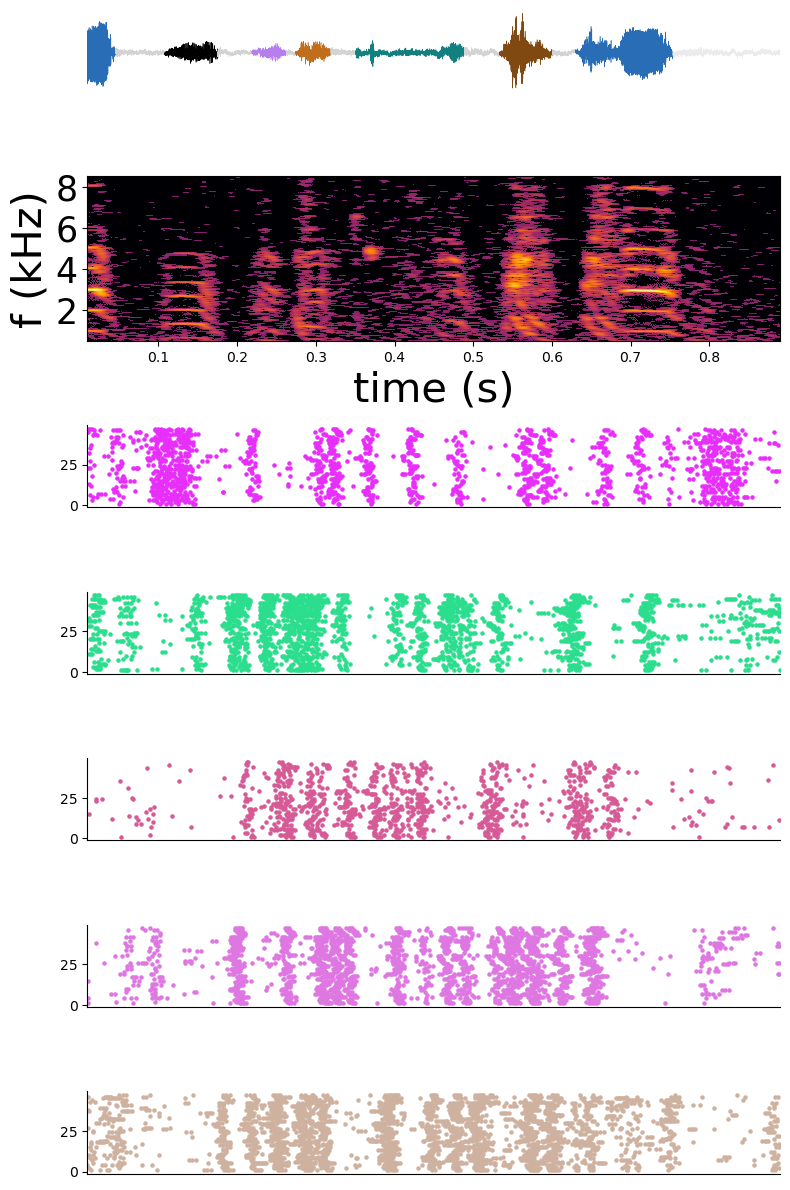

In [5]:
# Rasters to plot
plot_neurons = 5

# Create a figure and an array of axes with 5 rows
height_ratios = [1] + [2] + [1] * (plot_neurons)
gridspec_kw={'height_ratios': height_ratios}
fig, axs = plt.subplots(nrows=plot_neurons+2, ncols=1, figsize=(8, 12), gridspec_kw={'height_ratios': height_ratios})

# Plot sample motif
random_motif_idx = np.random.randint(audio_motifs.shape[0])

audio_lbl_edges = luts.TextgridLabels.find_label_edges_2D(audio_labels)
lbl_motif = audio_lbl_edges[random_motif_idx]
for idx in range(len(lbl_motif)-1):
    plt_color = colors[audio_labels[random_motif_idx, lbl_motif[idx]]] 
    start_time = lbl_motif[idx]                
    end_time   = lbl_motif[idx+1]+1 if idx != len(lbl_motif)-2 else lbl_motif[idx+1]    
    x_linspace = list(range(start_time, end_time))       
    axs[0].plot(x_linspace , audio_motifs[random_motif_idx][start_time:end_time], linewidth=0.4, color=plt_color)
for spine in axs[0].spines.values():
    spine.set_visible(False)
axs[0].set_xticks([]), axs[0].set_yticks([])
axs[0].margins(x=0)

# Plot motif spectrogram
plot_spectrogram(audio_motifs[random_motif_idx], fs_audio, ax=axs[1])

# Plot random rasters
random_indices = np.random.choice(spiketrains['ra_all'].shape[1], size=plot_neurons, replace=False)
for i, idx in enumerate(random_indices):
    plot_as_raster(spiketrains['ra_all'][:, idx, :], ax=axs[i+2])
    # Remove top and right spines
    axs[i+2].spines['top'].set_visible(False)
    axs[i+2].spines['right'].set_visible(False)
    axs[i+2].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)

plt.tight_layout()
plt.show()

## 2) Latent trajectories

keys():

- **'neural_dict'**: dictionary containing the trajectories inferred from HVC and RA activity in neural manifolds of different dimensionalities, using GPFA or PCA. Trajectories are stored in [trials x latent_dimensions x timesamps] format. e.g. (47, 12, 59)

- **'audio_motifs'**: Audio trials in [trials x timesamps] format. e.g. (47, 22499)
  
- **'audio_labels'**: Syllable labels for audio trials in [trials x timesamps] format. e.g. (47, 22499)
  
- **'fs_neural'**: Sampling frequency of neural trajectories. e.g. 66.6Hz (15ms bins).
  
- **'fs_audio'**: Sampling frequency of audio recordings. e.g. 25kHz.
  
- **'t_pre'**: Time before alignment sample (onset of syllable 1).
  
- **'t_post'**: Time after alignment sample (onset of syllable 1).
  
- **'sess_params'**: Experiment metadata (bird, session, probe etc.).

In [6]:
trajectories_filename = 'TRAJECTORIES_z_r12r13_21_20240426_030454_15msbins.pkl'

with open(trajectories_filename, 'rb') as file:
    state_space_analysis_dict = pkl.load(file)

# Unpack dictionary
trajectories_dict = state_space_analysis_dict['neural_dict']
audio_motifs = state_space_analysis_dict['audio_motifs']
audio_labels = state_space_analysis_dict['audio_labels']
fs_neural = state_space_analysis_dict['fs_neural']
fs_audio = state_space_analysis_dict['fs_audio']
t_pre, t_post = state_space_analysis_dict['t_pre'], state_space_analysis_dict['t_post']
sess_params = state_space_analysis_dict['sess_params']

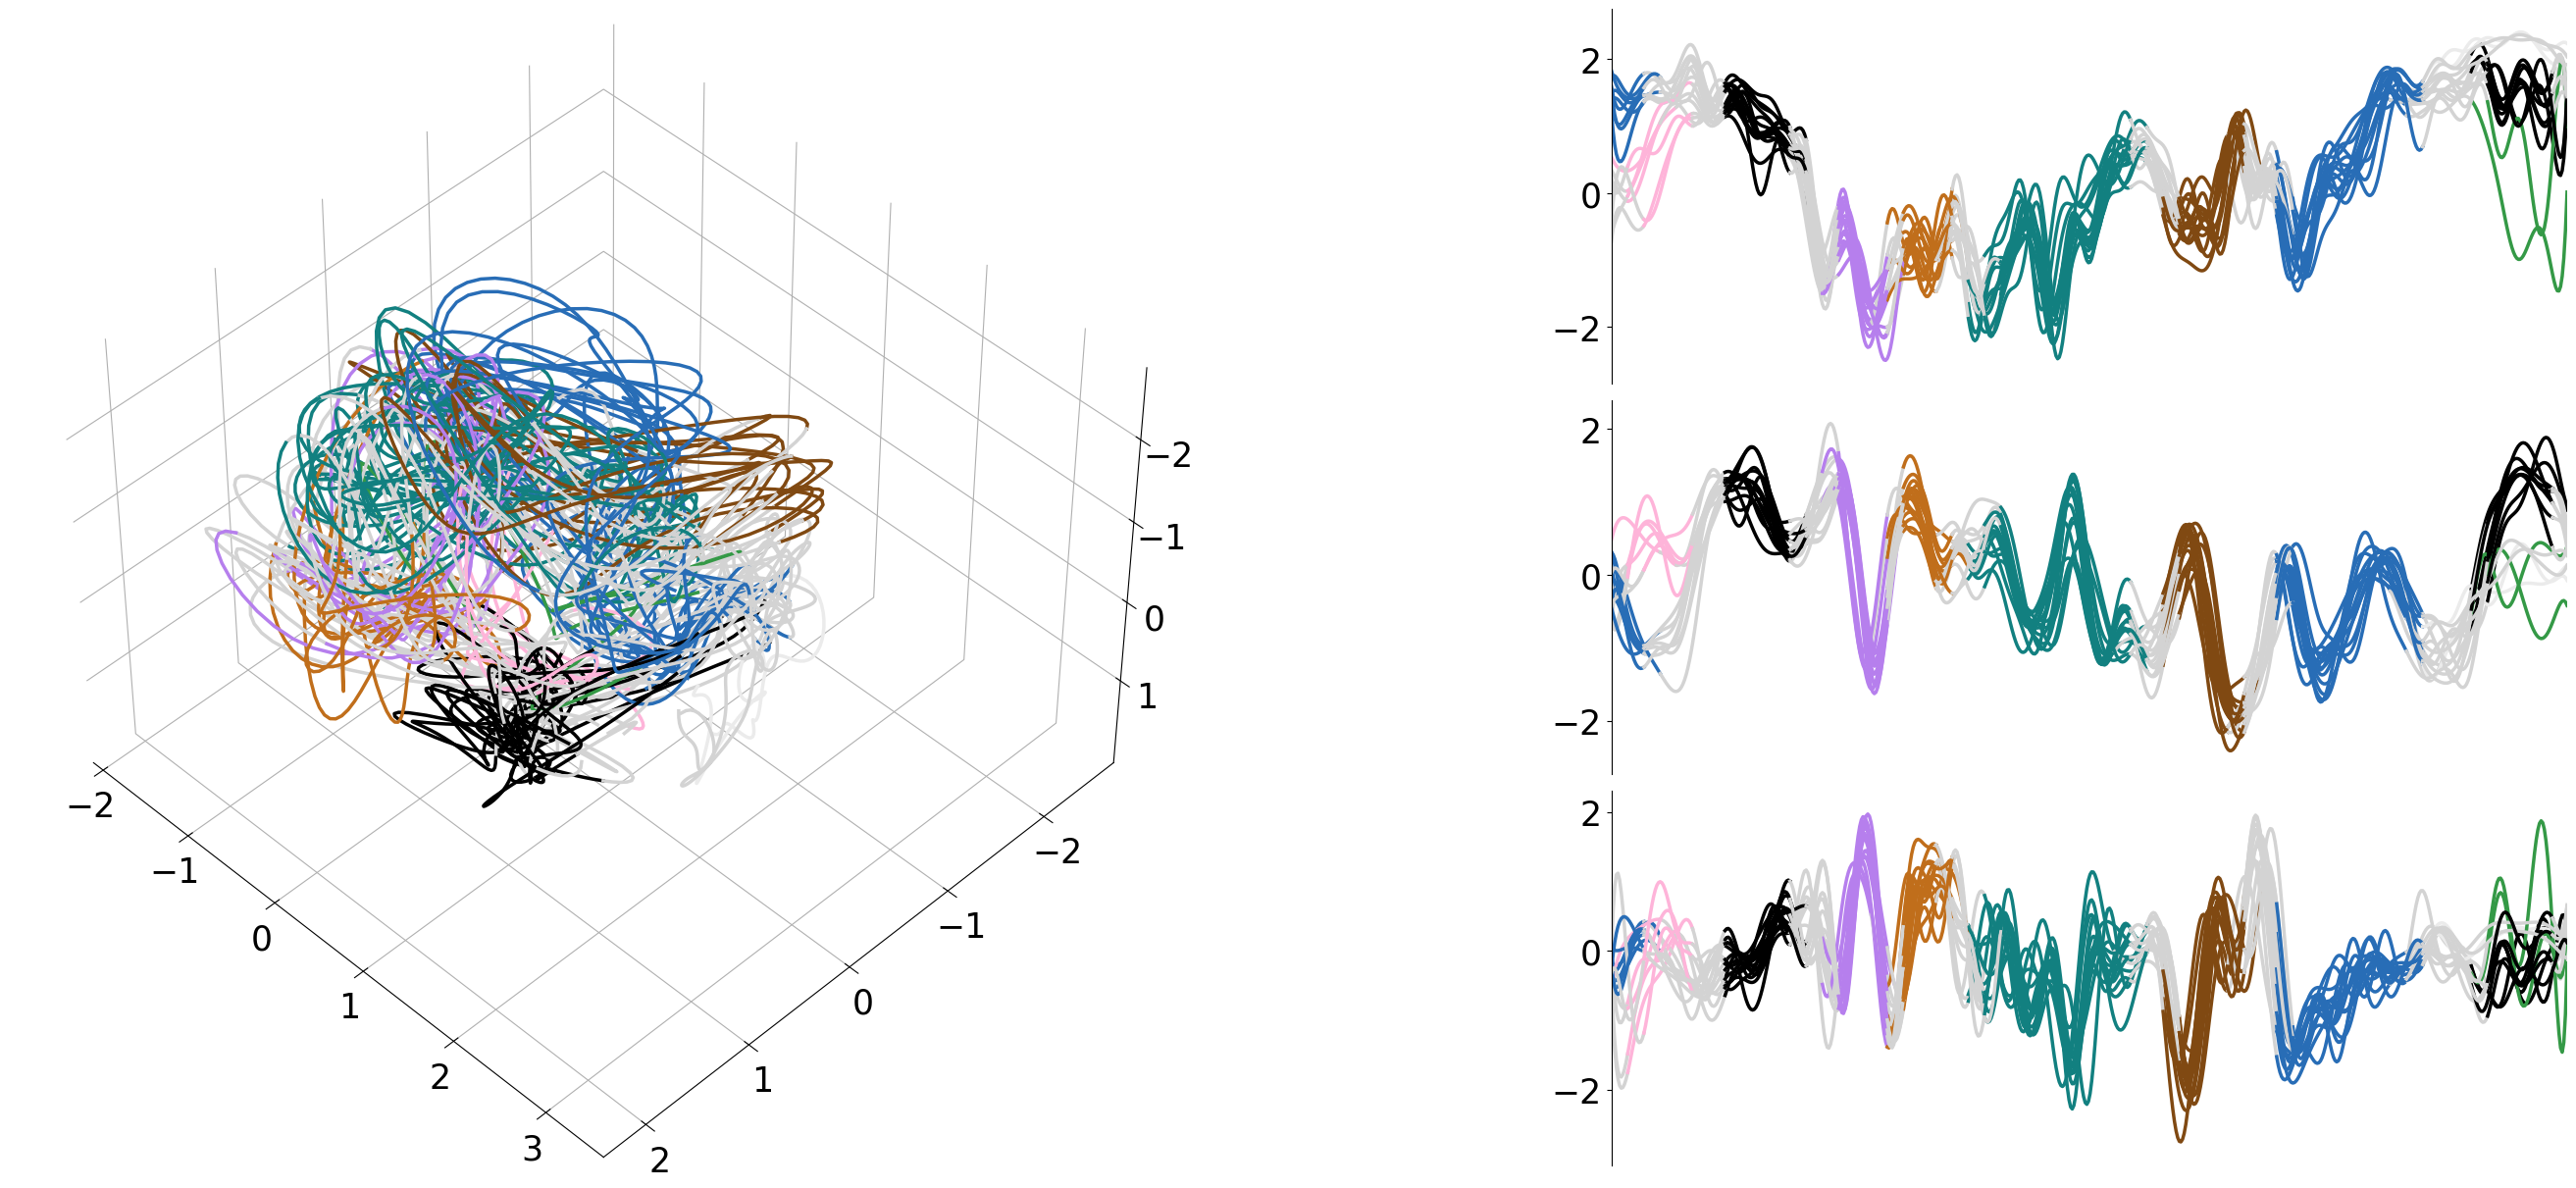

In [7]:
key, method, dimensionality = 'ra_all', 'gpfa', 8

# Trajectories and labels
trajectories = trajectories_dict[key][method][f'{key}_dim{dimensionality}']['trajectories']
bin_samples = audio_labels.shape[1] / trajectories.shape[2]
trajectory_labels = sh.downsample_list_2d(audio_labels, round(bin_samples), mode='mode')

# Smooth trajectories and labels
interpolation_multiplier = 10
interpolation_order = 5
smooth_trj = np.array([np.apply_along_axis(luts.TextgridLabels.signal_smoother, 1, trajectories[mot], interp_multiplier=interpolation_multiplier, interp_order=interpolation_order) for mot in range(len(trajectories))] )
smooth_trj_lbs = np.apply_along_axis(luts.TextgridLabels.list_expander, 1, trajectory_labels, expand_multiplier=interpolation_multiplier)

f = puts.plot_3D_trajectories(smooth_trj, trajectory_labels=smooth_trj_lbs, dimensions2plot=[0, 1, 2], num_trials2plot=15)